In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv


In [5]:
import string
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.12.0
TensorFlow Decision Forests v1.4.0


In [6]:
df_train_prompt = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv')
print("Full prompt train dataset shape is {}".format(df_train_prompt.shape))

Full prompt train dataset shape is (4, 4)


In [7]:
df_train_prompt.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [8]:
df_train_summaries = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv')
print("Full summaries train dataset shape is {}".format(df_train_summaries.shape))

Full summaries train dataset shape is (7165, 5)


In [9]:
df_train_summaries.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [10]:
df_train = df_train_summaries.merge(df_train_prompt, on='prompt_id')
print("Full summaries train dataset shape is {}".format(df_train.shape))

Full summaries train dataset shape is (7165, 8)


In [11]:
df_train.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...


In [12]:
df_train.describe()

,content,wording
count,7165.000000,7165.000000
mean,-0.014853,-0.063072
std,1.043569,1.036048
min,-1.729859,-1.962614
25%,-0.799545,-0.872720
50%,-0.093814,-0.081769
75%,0.499660,0.503833
max,3.900326,4.310693


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   student_id       7165 non-null   object 
 1   prompt_id        7165 non-null   object 
 2   text             7165 non-null   object 
 3   content          7165 non-null   float64
 4   wording          7165 non-null   float64
 5   prompt_question  7165 non-null   object 
 6   prompt_title     7165 non-null   object 
 7   prompt_text      7165 non-null   object 
dtypes: float64(2), object(6)
memory usage: 447.9+ KB


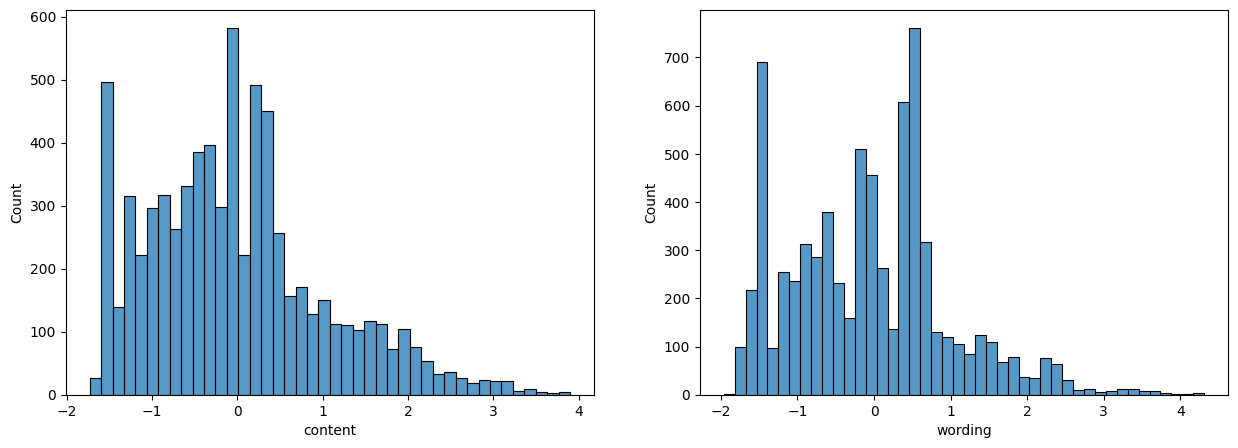

In [15]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df_train, x='content')
plt.subplot(1, 2, 2)
sns.histplot(data=df_train, x='wording')
plt.show()

In [17]:
# Reference: https://www.kaggle.com/code/sercanyesiloz/commonlit-tf-idf-xgb-baseline#4.-Feature-Engineering

# A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, 
# both when indexing entries for searching and when retrieving them as the result of a search query.
# Count the stop words in the text.
def count_stopwords(text: str) -> int:
    stopword_list = set(stopwords.words('english'))
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
    return stopwords_count

# Count the punctuations in the text.
# punctuation_set -> !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

# Count the digits in the text.
def count_numbers(text: str) -> int:
    numbers = re.findall(r'\d+', text)
    numbers_count = len(numbers)
    return numbers_count

# This function applies all the above preprocessing functions on a text feature.
def feature_engineer(dataframe: pd.DataFrame, feature: str = 'text') -> pd.DataFrame:
    dataframe[f'{feature}_word_cnt'] = dataframe[feature].apply(lambda x: len(x.split(' ')))
    dataframe[f'{feature}_length'] = dataframe[feature].apply(lambda x: len(x))
    dataframe[f'{feature}_stopword_cnt'] = dataframe[feature].apply(lambda x: count_stopwords(x))
    dataframe[f'{feature}_punct_cnt'] = dataframe[feature].apply(lambda x: count_punctuation(x))
    dataframe[f'{feature}_number_cnt'] = dataframe[feature].apply(lambda x: count_numbers(x))
    return dataframe

In [18]:
preprocessed_df = feature_engineer(df_train)
print("Full summaries train dataset shape is {}".format(preprocessed_df.shape))

Full summaries train dataset shape is (7165, 13)


In [19]:
preprocessed_df.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,text_word_cnt,text_length,text_stopword_cnt,text_punct_cnt,text_number_cnt
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,61,346,25,3,0
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,206,1225,92,30,3
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,60,345,27,9,0
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,76,451,35,10,0
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,27,145,12,2,0


In [20]:
preprocessed_df.describe()

,content,wording,text_word_cnt,text_length,text_stopword_cnt,text_punct_cnt,text_number_cnt
count,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000
mean,-0.014853,-0.063072,76.155618,418.776971,36.306769,9.355059,0.378786
std,1.043569,1.036048,54.538587,307.833685,25.813092,9.474397,0.937313
min,-1.729859,-1.962614,22.000000,114.000000,5.000000,0.000000,0.000000
25%,-0.799545,-0.872720,40.000000,216.000000,19.000000,4.000000,0.000000
50%,-0.093814,-0.081769,59.000000,320.000000,28.000000,6.000000,0.000000
75%,0.499660,0.503833,93.000000,513.000000,45.000000,12.000000,0.000000
max,3.900326,4.310693,651.000000,3940.000000,315.000000,162.000000,14.000000


In [22]:
FEATURE_COLUMNS = preprocessed_df.drop(columns = ['student_id', 'prompt_id', 'text', 'prompt_question', 
                                           'prompt_title', 'prompt_text', 'content', 'wording'], axis = 1).columns.to_list()

In [23]:
FEATURE_COLUMNS

['text_word_cnt',
 'text_length',
 'text_stopword_cnt',
 'text_punct_cnt',
 'text_number_cnt']

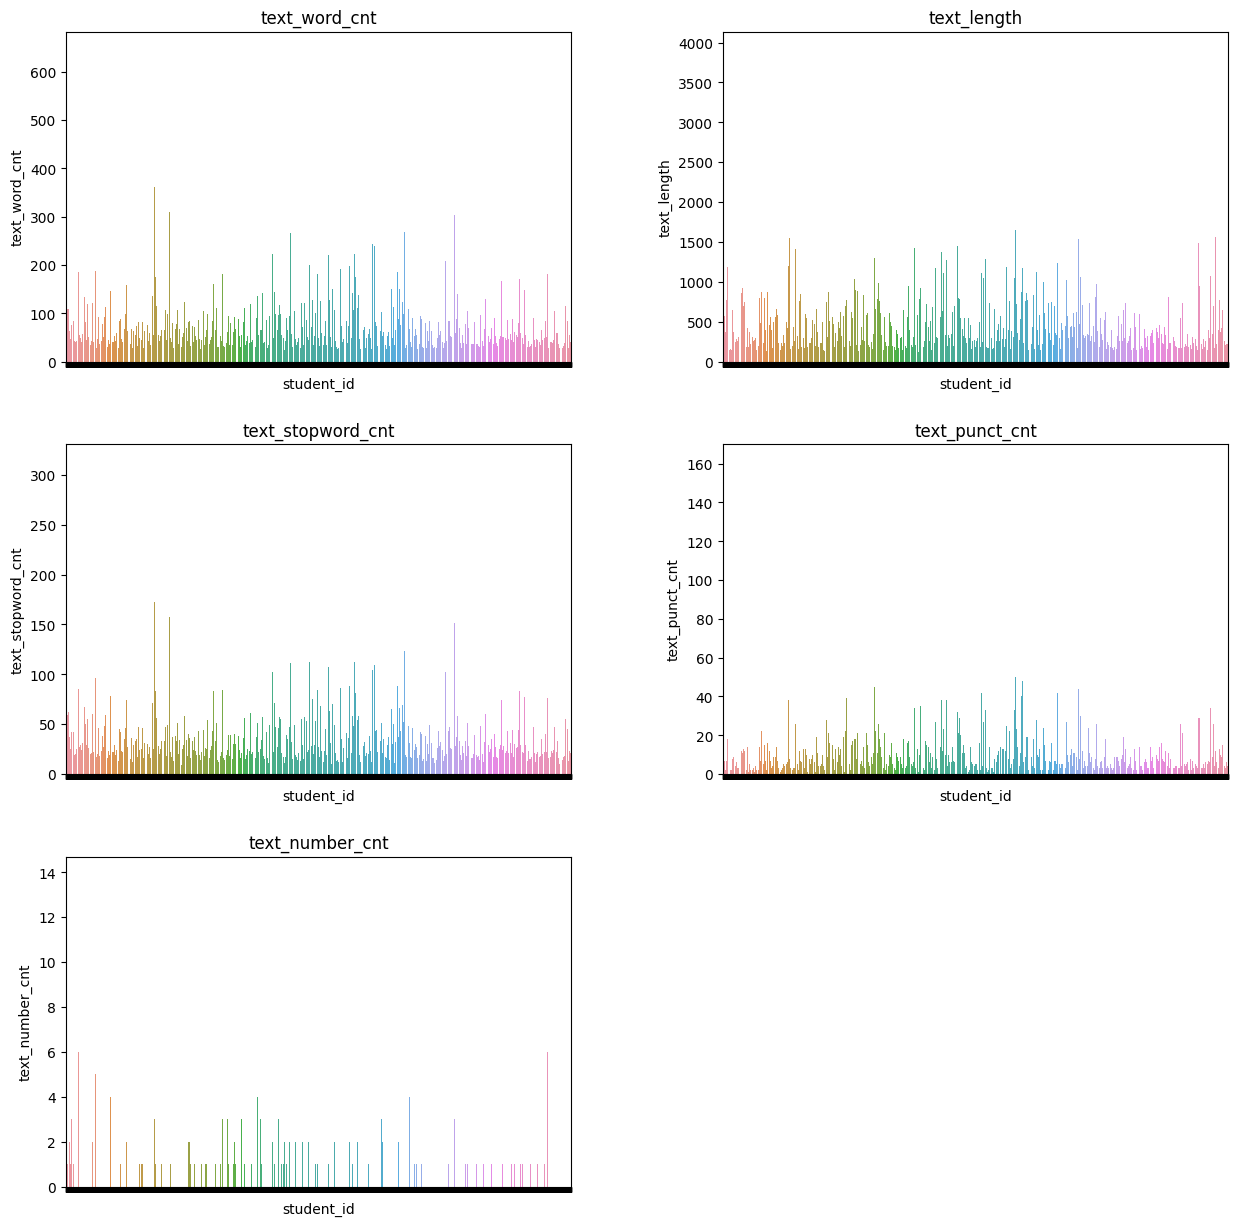

In [24]:
figure, axis = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.25, wspace=0.3)

for i, column_name in enumerate(FEATURE_COLUMNS):
    row = i//2
    col = i % 2
    bp = sns.barplot(ax=axis[row, col], x=preprocessed_df['student_id'], y=preprocessed_df[column_name])
    bp.set(xticklabels=[])
    axis[row, col].set_title(column_name)
axis[2, 1].set_visible(False)
plt.show()

In [25]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(preprocessed_df)
train_ds_pd.shape, valid_ds_pd.shape

((5759, 13), (1406, 13))

In [26]:
train_ds_pd.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,text_word_cnt,text_length,text_stopword_cnt,text_punct_cnt,text_number_cnt
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,61,346,25,3,0
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,206,1225,92,30,3
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,60,345,27,9,0
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,27,145,12,2,0
6,01d303ea2f62,814d6b,The Third Wave developed and spead over such a...,0.735204,2.346576,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,133,767,68,16,0


In [28]:
# `content` label datatset columns
FEATURE_CONTENT = FEATURE_COLUMNS + ['content']

# `wording` label datatset columns
FEATURE_WORDING = FEATURE_COLUMNS + ['wording']

# Convert dataframes to corresponding datasets
content_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd[FEATURE_CONTENT], label='content', task = tfdf.keras.Task.REGRESSION)
wording_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd[FEATURE_WORDING], label='wording', task = tfdf.keras.Task.REGRESSION)

In [29]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [30]:
rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1")

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmps7078341 as temporary training directory


In [31]:
# Create RandomForestModel for label content
model_content = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model_content.compile(metrics=["mse"])

# Create RandomForestModel for label wording
model_wording = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model_wording.compile(metrics=["mse"])

Use /tmp/tmpte1qij7l as temporary training directory
Use /tmp/tmpr8byy8ac as temporary training directory


In [32]:
# Training RandomForestModel for label content
model_content.fit(x=content_train_ds)

# Training RandomForestModel for label wording
model_wording.fit(x=wording_train_ds)

Reading training dataset...
Training dataset read in 0:00:06.676451. Found 5759 examples.
Training model...


[INFO 23-09-30 07:30:52.5276 UTC kernel.cc:1243] Loading model from path /tmp/tmpte1qij7l/model/ with prefix 12dfa783538f4a84


Model trained in 0:00:04.359791
Compiling model...


[INFO 23-09-30 07:30:54.4330 UTC decision_forest.cc:660] Model loaded with 300 root(s), 465044 node(s), and 5 input feature(s).
[INFO 23-09-30 07:30:54.4332 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-30 07:30:54.4333 UTC kernel.cc:1075] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
Reading training dataset...
Training dataset read in 0:00:00.191748. Found 5759 examples.
Training model...


[INFO 23-09-30 07:30:58.8234 UTC kernel.cc:1243] Loading model from path /tmp/tmpr8byy8ac/model/ with prefix 8de17fabf4d94ee6


Model trained in 0:00:03.988616
Compiling model...


[INFO 23-09-30 07:31:00.5308 UTC decision_forest.cc:660] Model loaded with 300 root(s), 445520 node(s), and 5 input feature(s).
[INFO 23-09-30 07:31:00.5308 UTC kernel.cc:1075] Use fast generic engine


Model compiled.


In [33]:
# Visualize model_content
tfdf.model_plotter.plot_model_in_colab(model_content, tree_idx=0, max_depth=3)

In [34]:
# Visualize model_content
tfdf.model_plotter.plot_model_in_colab(model_wording, tree_idx=0, max_depth=3)

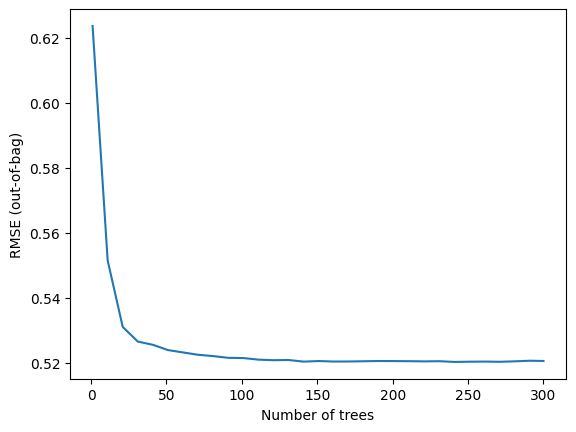

In [35]:
# Plot log data for model_content
logs = model_content.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

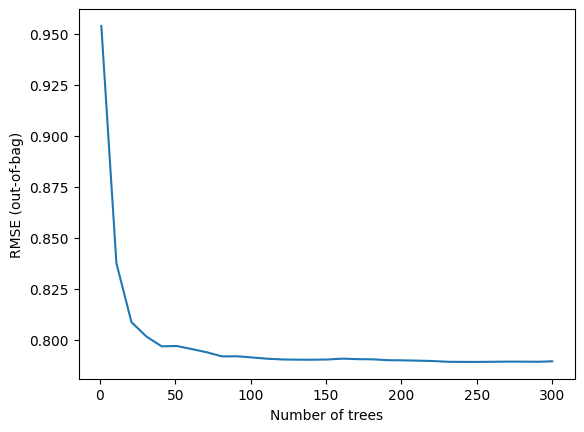

In [36]:
# Plot log data for model_wording
logs = model_wording.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [37]:
# General stats for model_content
inspector_content = model_content.make_inspector()
inspector_content.evaluation()

Evaluation(num_examples=5759, accuracy=None, loss=None, rmse=0.5205896232950533, ndcg=None, aucs=None, auuc=None, qini=None)

In [38]:
# General stats for model_wording
inspector_wording = model_wording.make_inspector()
inspector_wording.evaluation()

Evaluation(num_examples=5759, accuracy=None, loss=None, rmse=0.7895145580255675, ndcg=None, aucs=None, auuc=None, qini=None)

In [41]:
# Create validation dataset for model_content
valid_ds_content = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd[FEATURE_CONTENT], label="content", task = tfdf.keras.Task.REGRESSION)

# Create validation dataset for model_wording
valid_ds_wording = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd[FEATURE_WORDING], label="wording", task = tfdf.keras.Task.REGRESSION)

# Run evaluation for model_content
evaluation_content = model_content.evaluate(x=valid_ds_content,return_dict=True)
for name, value in evaluation_content.items():
  print(f"{name}: {value:.4f}")

# Run evaluation for model_wording
evaluation_wording = model_wording.evaluate(x=valid_ds_wording,return_dict=True)
for name, value in evaluation_wording.items():
  print(f"{name}: {value:.4f}")

2/2 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - mse: 0.3005
loss: 0.0000
mse: 0.3005
2/2 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - mse: 0.6965
loss: 0.0000
mse: 0.6965


In [42]:
print(f"Available variable importances for model_content:")
for importance in inspector_content.variable_importances().keys():
  print("\t", importance)

Available variable importances for model_content:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES


In [43]:
print(f"Available variable importances for model_wording:")
for importance in inspector_wording.variable_importances().keys():
  print("\t", importance)

Available variable importances for model_wording:
	 NUM_NODES
	 NUM_AS_ROOT
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE


In [44]:
inspector_content.variable_importances()["NUM_AS_ROOT"]

[("text_length" (1; #1), 168.0),
 ("text_word_cnt" (1; #5), 90.0),
 ("text_stopword_cnt" (1; #4), 42.0)]

In [45]:
inspector_wording.variable_importances()["NUM_AS_ROOT"]

[("text_length" (1; #1), 168.0),
 ("text_word_cnt" (1; #5), 75.0),
 ("text_stopword_cnt" (1; #4), 57.0)]

In [46]:
df_test_prompt = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv')
df_test_summaries = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv')

In [47]:
df_test = df_test_summaries.merge(df_test_prompt, on='prompt_id')

In [48]:
df_test.head()

,student_id,prompt_id,text,prompt_question,prompt_title,prompt_text
0,000000ffffff,abc123,Example text 1,Summarize...,Example Title 1,Heading\nText...
1,222222cccccc,abc123,Example text 3,Summarize...,Example Title 1,Heading\nText...
2,111111eeeeee,def789,Example text 2,Summarize...,Example Title 2,Heading\nText...
3,333333dddddd,def789,Example text 4,Summarize...,Example Title 2,Heading\nText...


In [49]:
processed_test_df = feature_engineer(df_test)

In [50]:
processed_test_df.head()

,student_id,prompt_id,text,prompt_question,prompt_title,prompt_text,text_word_cnt,text_length,text_stopword_cnt,text_punct_cnt,text_number_cnt
0,000000ffffff,abc123,Example text 1,Summarize...,Example Title 1,Heading\nText...,3,14,0,0,1
1,222222cccccc,abc123,Example text 3,Summarize...,Example Title 1,Heading\nText...,3,14,0,0,1
2,111111eeeeee,def789,Example text 2,Summarize...,Example Title 2,Heading\nText...,3,14,0,0,1
3,333333dddddd,def789,Example text 4,Summarize...,Example Title 2,Heading\nText...,3,14,0,0,1


In [51]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(processed_test_df[FEATURE_COLUMNS], task = tfdf.keras.Task.REGRESSION)

In [52]:
processed_test_df['content'] = model_content.predict(test_ds)
processed_test_df['wording'] = model_wording.predict(test_ds)

1/1 [==============================] - 0s 30ms/step


In [53]:
processed_test_df.head()

,student_id,prompt_id,text,prompt_question,prompt_title,prompt_text,text_word_cnt,text_length,text_stopword_cnt,text_punct_cnt,text_number_cnt,content,wording
0,000000ffffff,abc123,Example text 1,Summarize...,Example Title 1,Heading\nText...,3,14,0,0,1,-1.398151,-1.389813
1,222222cccccc,abc123,Example text 3,Summarize...,Example Title 1,Heading\nText...,3,14,0,0,1,-1.398151,-1.389813
2,111111eeeeee,def789,Example text 2,Summarize...,Example Title 2,Heading\nText...,3,14,0,0,1,-1.398151,-1.389813
3,333333dddddd,def789,Example text 4,Summarize...,Example Title 2,Heading\nText...,3,14,0,0,1,-1.398151,-1.389813


In [54]:
processed_test_df[['student_id', 'content', 'wording']].to_csv('submission.csv',index=False)
display(pd.read_csv('submission.csv'))

,student_id,content,wording
0,000000ffffff,-1.398151,-1.389813
1,222222cccccc,-1.398151,-1.389813
2,111111eeeeee,-1.398151,-1.389813
3,333333dddddd,-1.398151,-1.389813
